In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/MyDrive/teeth.rar'

In [3]:
data = !unrar x /content/drive/MyDrive/teeth.rar

In [9]:
import os
from collections import Counter
main_directory = '/content/teeth/new teeth data'
class_names = os.listdir(main_directory)
class_counts = {class_name: len(os.listdir(os.path.join(main_directory, class_name))) for class_name in class_names}
print("Number of images per class:", class_counts)

Number of images per class: {'MC': 1620, 'CoS': 1350, 'Gum': 1079, 'OC': 972, 'OLP': 1619, 'OT': 1179, 'CaS': 1440}


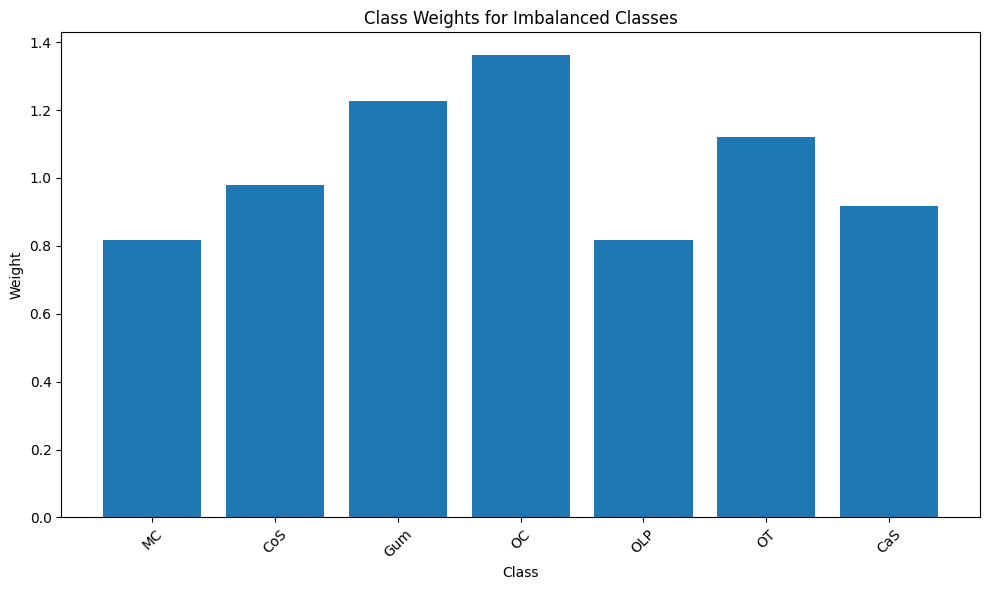

In [10]:
main_directory = '/content/teeth/new teeth data'
class_names = os.listdir(main_directory)
class_counts = {class_name: len(os.listdir(os.path.join(main_directory, class_name))) for class_name in class_names}
total_images = sum(class_counts.values())
class_weights = {i: total_images / (len(class_names) * count) for i, (class_name, count) in enumerate(class_counts.items())}
plt.figure(figsize=(10, 6))
plt.bar(class_weights.keys(), class_weights.values(), tick_label=class_names)
plt.xlabel('Class')
plt.ylabel('Weight')
plt.title('Class Weights for Imbalanced Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Importing needed lib

In [11]:
total_images = sum(class_counts.values())
class_weights = {i: total_images / (len(class_names) * count) for i, (class_name, count) in enumerate(class_counts.items())}
print("Computed Class Weights:", class_weights)


Computed Class Weights: {0: 0.8164902998236332, 1: 0.9797883597883598, 2: 1.2258705150271416, 3: 1.360817166372722, 4: 0.8169946174887497, 5: 1.121895068459954, 6: 0.9185515873015873}


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential,regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import random
import numpy as np
import os
from matplotlib import pyplot as plt


visualize 2 images from each class before Augmentation

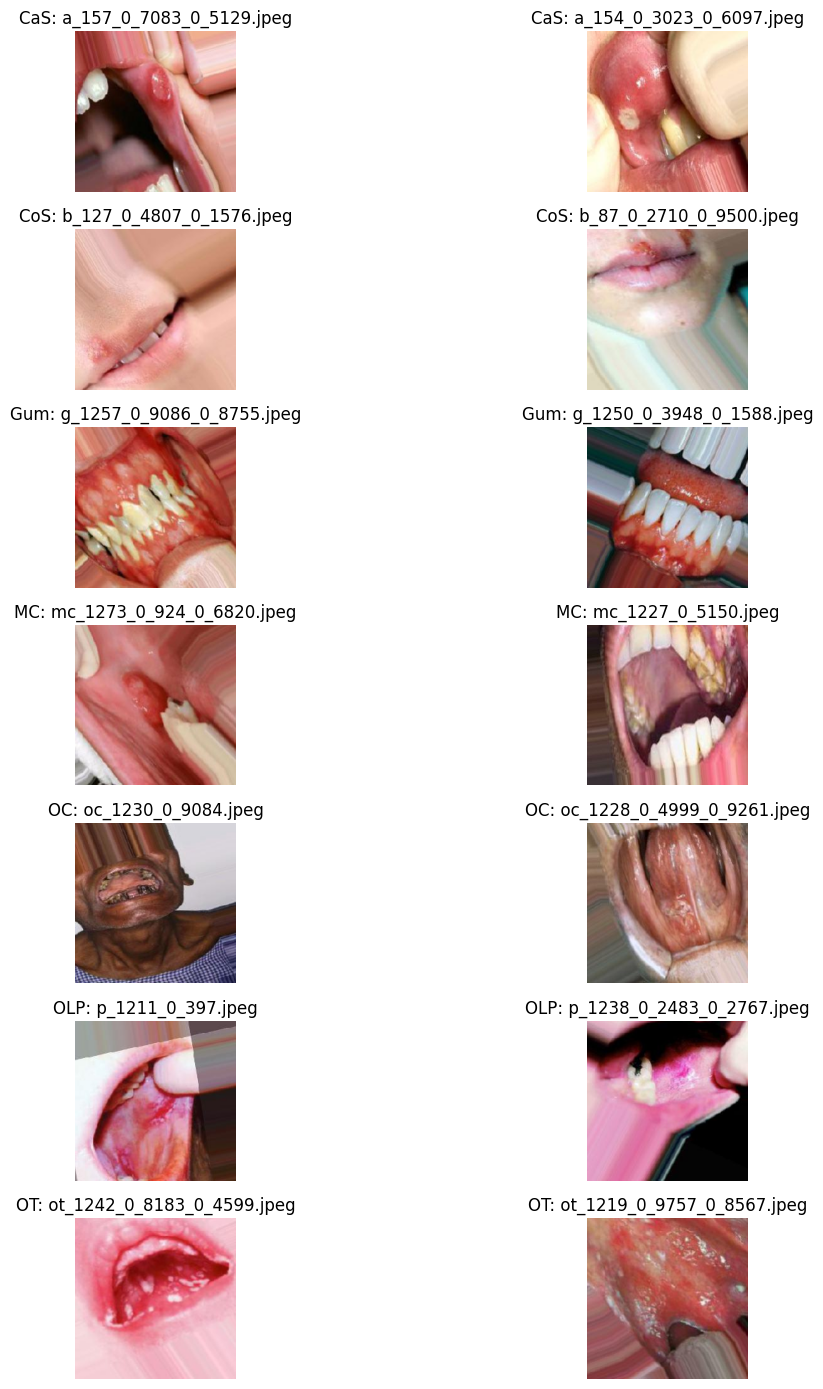

In [5]:
# List of folder paths
folders = [r'/content/teeth/new teeth data/CaS', r'/content/teeth/new teeth data/CoS', r'/content/teeth/new teeth data/Gum',
           r'/content/teeth/new teeth data/MC', r'/content/teeth/new teeth data/OC', r'/content/teeth/new teeth data/OLP',r'/content/teeth/new teeth data/OT']

# Display 2 images from each folder
plt.figure(figsize=(14, 14))
image_count = 1

for folder_path in folders:
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Display the first 2 images in each folder
    for image_file in image_files[:2]:
        img = load_img(os.path.join(folder_path, image_file), target_size=(224, 224))  # Resize for uniformity
        img_array = img_to_array(img) / 255.0  # Normalize the images
        plt.subplot(7, 2, image_count)
        plt.imshow(img_array)
        plt.title(f"{os.path.basename(folder_path)}: {image_file}")
        plt.axis('off')
        image_count += 1

plt.tight_layout()
plt.show()


Data Augmentation

In [ ]:
# Create an instance of ImageDataGenerator with some common augmentations
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directory where the augmented images will be saved
save_dir = r'E:\new teeth data'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Loop through each folder
for folder_path in folders:
    class_name = os.path.basename(folder_path)
    class_save_dir = os.path.join(save_dir, class_name)
    if not os.path.exists(class_save_dir):
        os.makedirs(class_save_dir)

    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Augment images in each folder
    for image_file in image_files:
        img = load_img(os.path.join(folder_path, image_file))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate 3 augmented images per original image
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=class_save_dir, save_prefix=image_file.split('.')[0], save_format='jpeg'):
            i += 1
            if i >=3:
                break

Augmented data


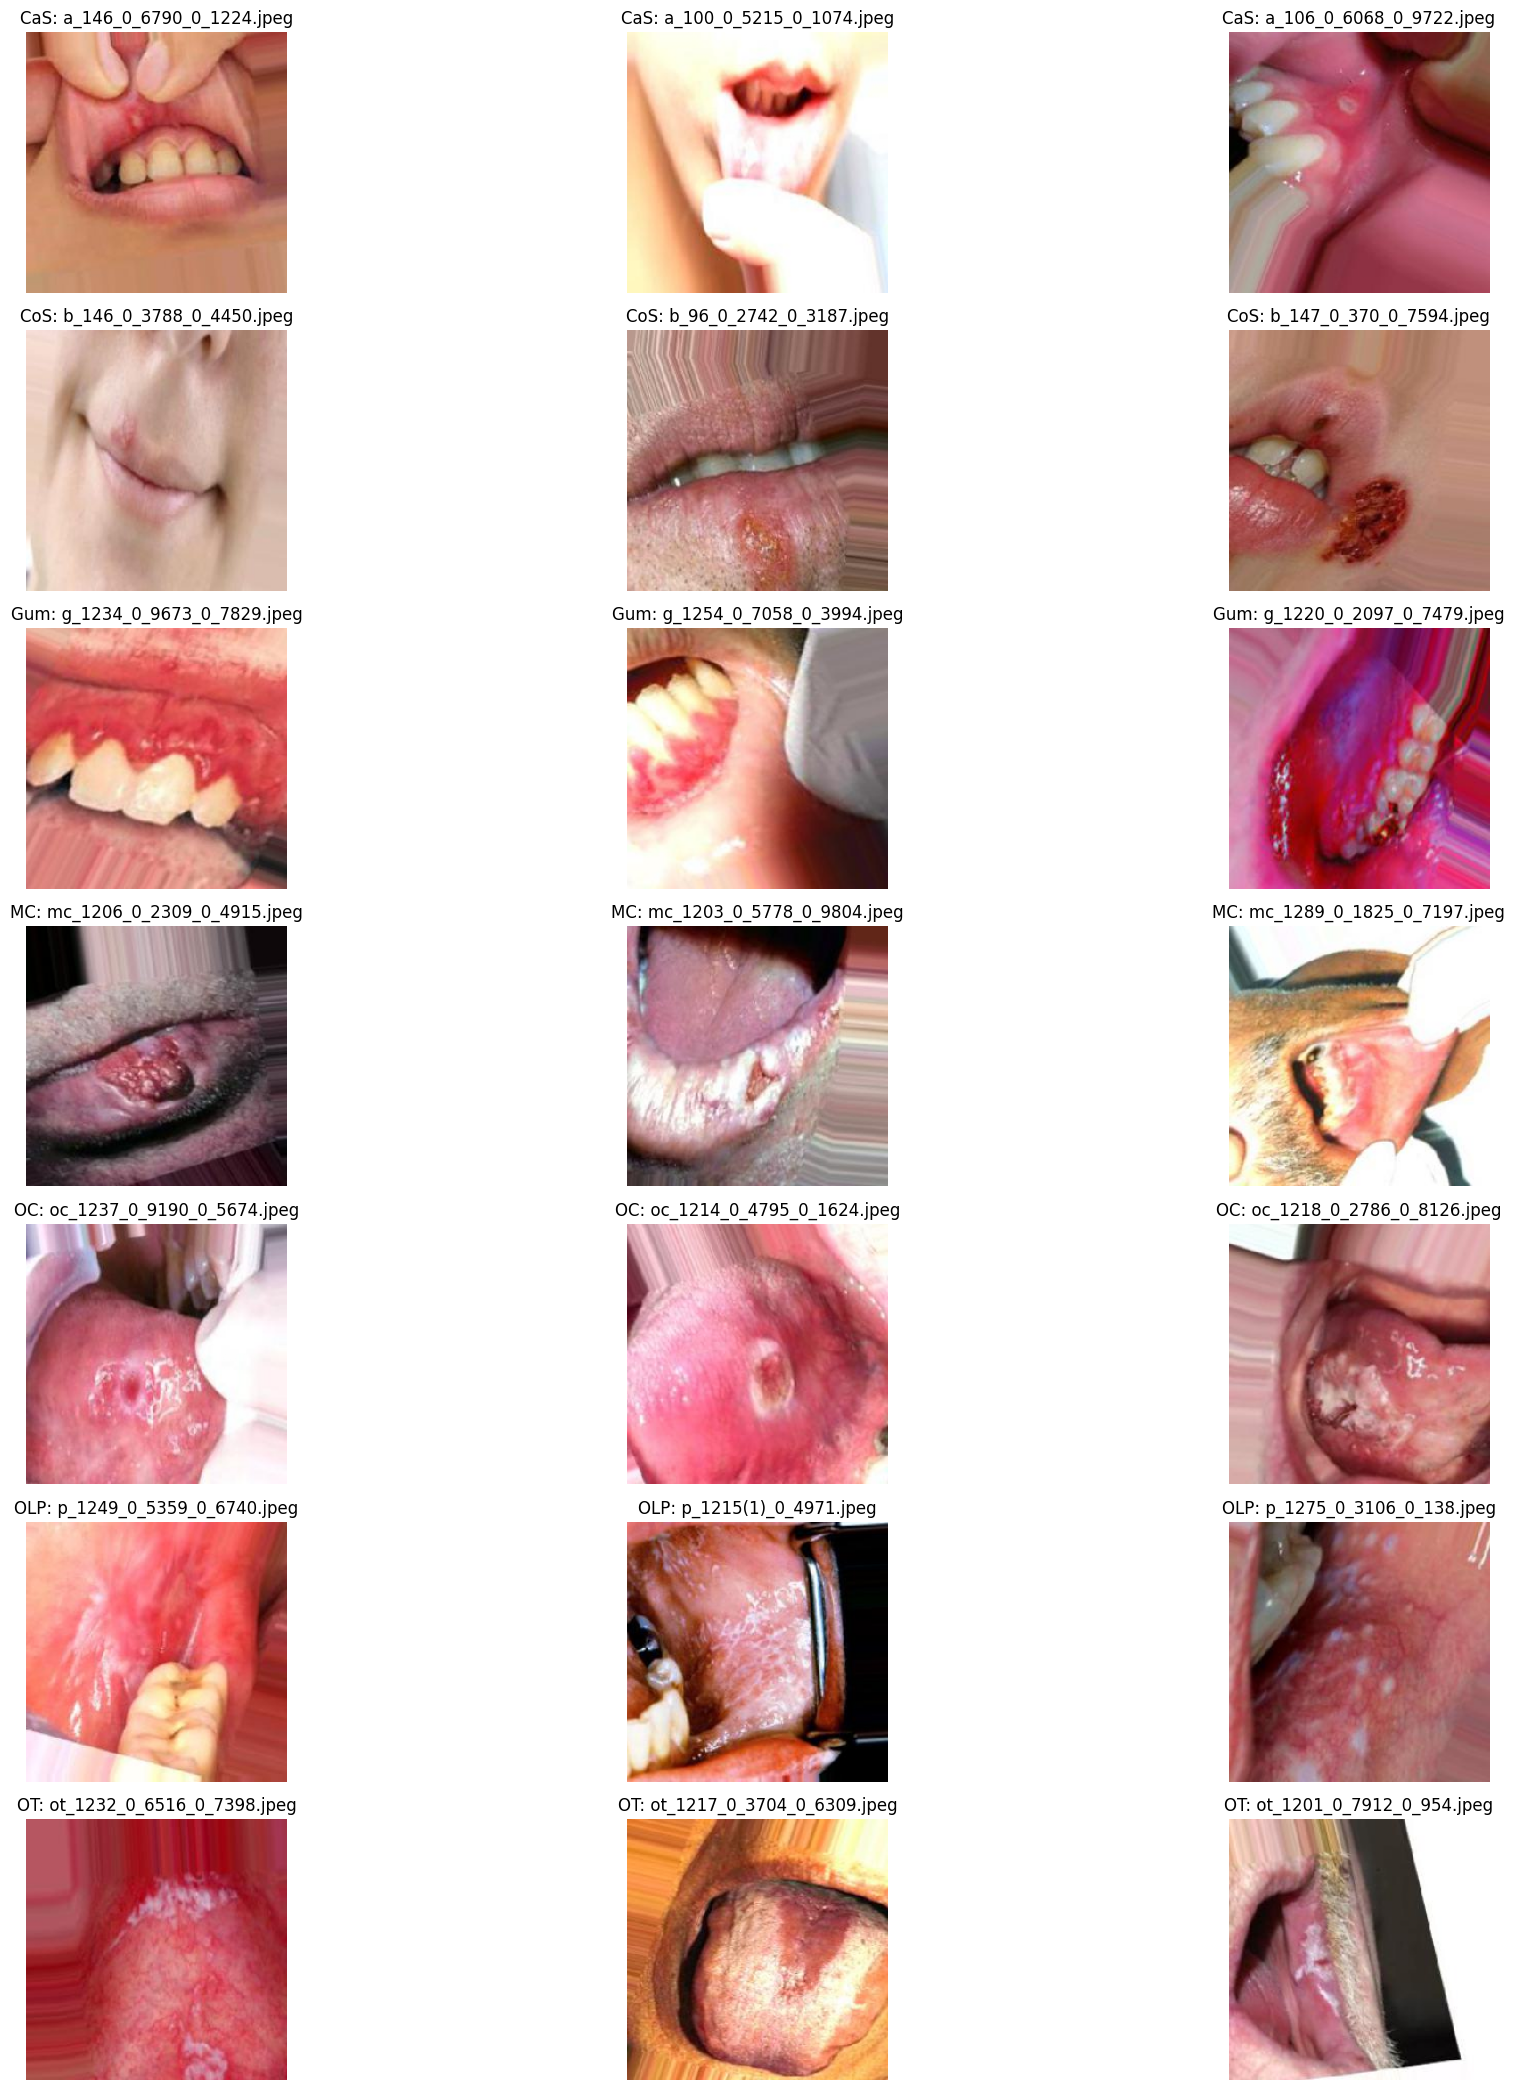

In [6]:
new_folders = [r'/content/teeth/new teeth data/CaS', r'/content/teeth/new teeth data/CoS', r'/content/teeth/new teeth data/Gum',
           r'/content/teeth/new teeth data/MC', r'/content/teeth/new teeth data/OC', r'/content/teeth/new teeth data/OLP',r'/content/teeth/new teeth data/OT']

# Display 3 random images from each folder
plt.figure(figsize=(21, 21))
image_count = 1

for folder_path in new_folders:
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    random_images = random.sample(image_files, 3)

    # Display the selected images
    for image_file in random_images:
        img = load_img(os.path.join(folder_path, image_file), target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        plt.subplot(7, 3, image_count)
        plt.imshow(img_array)
        plt.title(f"{os.path.basename(folder_path)}: {image_file}")
        plt.axis('off')
        image_count += 1

plt.tight_layout()
plt.show()

Reading and preprocessing the data

In [37]:
train_dir =r"/content/teeth/new teeth data"
validation_dir = r"/content/teeth/Validation"
test_dir = r"/content/teeth/Testing"
# Define batch size and image size
batch_size = 64
img_size = (224, 224)

# Load the training dataset with categorical labels
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Load the validation dataset with categorical labels
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Load the test dataset with categorical labels
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)


Found 9259 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [39]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [40]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


In [41]:
model = models.Sequential([
    base_model,                      # Add the base model
    layers.GlobalAveragePooling2D(), # Add global average pooling
    layers.Dense(512, activation='relu'), # Add a fully connected layer
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])


In [49]:
checkpoint = ModelCheckpoint(
    'best_model.keras',                 # File path to save the model
    monitor='val_accuracy',          # Metric to monitor
    save_best_only=True,              # Save only the best model
    mode='max',                      # Mode for the metric: 'max' for accuracy
    verbose=1                        # Print messages when saving the model
)


Bulding the model Archticture

In [43]:
# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [44]:
# Train the model using the train and validation datasets
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks=[checkpoint],
    class_weight=class_weights
)

Epoch 1/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3575 - loss: 2.0943
Epoch 1: val_accuracy improved from -inf to 0.72860, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 91s 438ms/step - accuracy: 0.3582 - loss: 2.0908 - val_accuracy: 0.7286 - val_loss: 0.7928
Epoch 2/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6360 - loss: 1.0146
Epoch 2: val_accuracy improved from 0.72860 to 0.82296, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 40s 273ms/step - accuracy: 0.6363 - loss: 1.0139 - val_accuracy: 0.8230 - val_loss: 0.4913
Epoch 3/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7609 - loss: 0.6851
Epoch 3: val_accuracy improved from 0.82296 to 0.86965, saving model to best_model.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.7612 - loss: 0.6847 - val_accuracy: 0.8696 - val_loss: 0.3550
Epoch 4/40
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8554 - loss: 0.4670
Epoch 4: val_accuracy im

In [50]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9879 - loss: 0.0536
Test Accuracy: 0.9795719981193542


In [51]:
model.save('pretrained_teeth_model.h5')

In [52]:
ypred=model.predict(test_dataset)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step


In [56]:
ypred_classes = np.argmax(ypred, axis=1)


In [57]:
ypred_classes

array([0, 0, 0, ..., 6, 6, 6])

In [60]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)  # If using one-hot encoded labels


In [61]:
y_true

array([0, 0, 0, ..., 6, 6, 6])

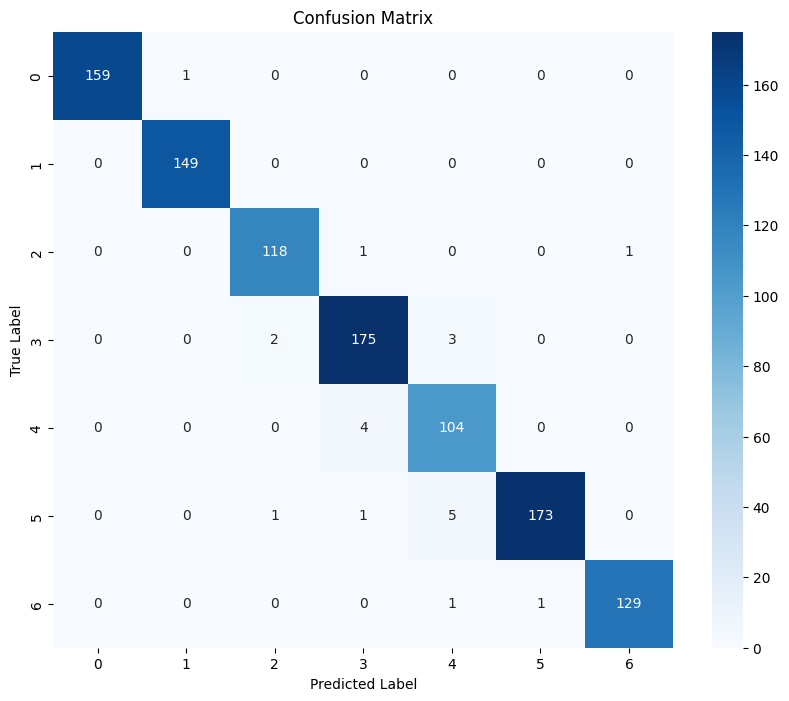

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_true, ypred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
